In [1]:
import pandas as pd
import numpy as np
# import shap
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import LearningCurveDisplay
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn import decomposition 
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import m2cgen as m2c

# Import data

In [2]:
# Read excel data
data_all = pd.read_excel('E:\Machine Learning\summary.xlsx',sheet_name='Sheet1', header=0,index_col=None)
data = data_all.iloc[:,2:15]
# print(data)
# Convert dataframe to matrix
data_value = data.iloc[:,:].values
X = data_value[:,1:].astype(float)
y = data_value[:,0]
# print(y)
print(X.shape,y.shape)

(4908, 12) (4908,)


In [6]:
X

array([[8.07300e+03, 8.17500e+03, 1.00000e-02, ..., 5.90000e+00,
        1.37000e+00, 1.83000e+00],
       [9.32500e+03, 7.76270e+04, 1.50000e-02, ..., 2.90000e+00,
        1.00000e-02, 1.40000e-01],
       [5.88300e+03, 1.14676e+05, 1.50000e-02, ..., 1.48000e+01,
        2.00000e-02, 4.00000e-01],
       ...,
       [7.44330e+01, 4.80000e+03, 8.69000e-01, ..., 2.01100e+00,
        5.44100e+00, 3.48400e+00],
       [5.53220e+01, 4.90000e+03, 8.35000e-01, ..., 7.55000e-01,
        5.77000e-01, 6.69000e-01],
       [5.84250e+01, 5.00000e+03, 9.71000e-01, ..., 7.86000e-01,
        5.42000e-01, 6.59000e-01]])

# Encoding labels

In [4]:
Xrows, Xcols = X.shape
color = ['b','r','g','y','c']
label = ['epithermal','skarn','MVT','VMS','SEDEX']
elements = ['Mn','Fe','Co','Cu','Ga','Ge','Ag','Cd','In','Sn','Sb','Pb']
label_length = len(label)
enc = preprocessing.LabelEncoder()
enc = enc.fit(label)
y = enc.transform(y)
print(y)

[3 3 3 ... 1 1 1]


In [35]:
enc.inverse_transform([0,1,2,3,4])

array(['MVT', 'SEDEX', 'VMS', 'epithermal', 'skarn'], dtype='<U10')

# violinplots

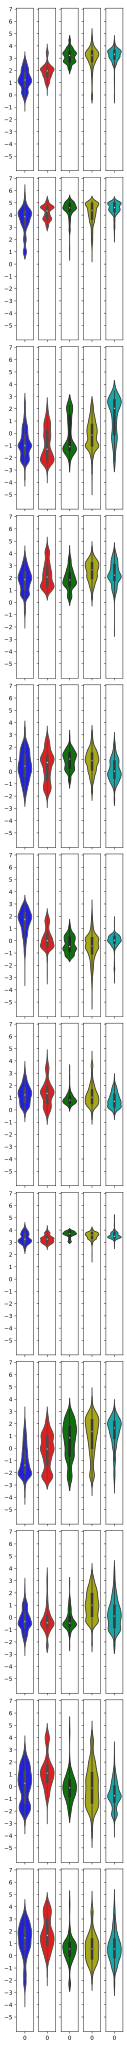

In [36]:
# sns.set_theme(style="whitegrid")
f, ax = plt.subplots(Xcols,label_length,sharex = 'col',sharey= all,figsize=(3,50),layout='compressed')
for i in range(Xcols):
     for j in range(label_length):
        sns.violinplot(data=np.log10(X[y==j,i]),cut=2,width=0.8,inner = 'box',ax=ax[i][j],color=color[j])

plt.yticks(np.arange(-5,8,1))
# plt.savefig('violinplot.pdf', dpi=800, bbox_inches='tight')

# Divide the training set, cross validation set, and testing set

In [4]:
Xtrain, Xtest, ytrain, ytest = train_test_split(np.log10(X), y, test_size=0.2, random_state=2023, shuffle=True, stratify= None)

# training models

## DecisionTree

In [6]:
dtc = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, 
                             min_impurity_decrease=0.0, class_weight='balanced', ccp_alpha=0.0)   
dtc = dtc.fit(Xtrain, ytrain)
score_c = dtc.score(Xtest, ytest)
print(score_c)
print(dtc.feature_importances_)

0.929735234215886
[0.22408764 0.10974853 0.12309494 0.03052736 0.0460419  0.1258542
 0.04809787 0.07745823 0.03888389 0.08567095 0.06220596 0.02832852]


In [7]:
haobugao = pd.read_excel('E:\\Machine Learning\\sphalerite.xlsx',sheet_name='Sheet3', header=0,index_col=0)
X_haobugao = haobugao.iloc[:,:].values
# print(X_haobugao)
prd = dtc.predict(np.log10(X_haobugao))
print(prd)

[3 4 4 1 4 4 4 4 3 4 3 1 1 4 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 3 4 4 4
 4 4 4 4 4]


## Random Forest

In [5]:
# Grid search for optimal hyperparameters
rf_estimators = range(1,121,10)
rf_features = range(1,13,1)
params_rf = {'n_estimators': rf_estimators, 'max_features': rf_features}
rf_model = GridSearchCV(RandomForestClassifier(),params_rf,scoring = 'f1_macro', cv=10,n_jobs=-1)
rf_model.fit(Xtrain, ytrain)

GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_features': range(1, 13),
                         'n_estimators': range(1, 121, 10)},
             scoring='f1_macro')

In [6]:
print(rf_model.best_score_, rf_model.best_params_)
rf_params_scores = rf_model.cv_results_['mean_test_score'].reshape(len(rf_features),len(rf_estimators))
# print(rf_model.cv_results_)
# print(rf_params_scores)

0.975169386284499 {'max_features': 2, 'n_estimators': 71}


Text(94.58333333333333, 0.5, 'max_features')

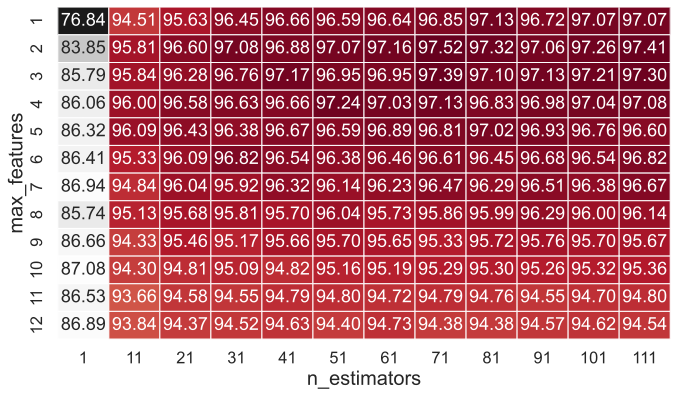

In [7]:
# Visualization
sns.set_theme(context='talk', style='darkgrid', palette='pastel', font='Arial', font_scale=1, color_codes=True, rc=None)

f, ax = plt.subplots(figsize=(11, 6))
sns.heatmap(rf_params_scores*100, annot=True,fmt=".2f", cmap='RdGy_r', linewidths=1, 
            xticklabels = rf_estimators, yticklabels = rf_features, cbar=None)
plt.xlabel("n_estimators",font='Arial',fontsize=20)
plt.ylabel("max_features",font='Arial',fontsize=20)
# plt.savefig('Grid_search_rfc.pdf', dpi=800, bbox_inches='tight')

In [5]:
rfc = RandomForestClassifier(n_estimators=91, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,
                             min_weight_fraction_leaf=0.0, max_features= 2, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                             bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, 
                             class_weight='balanced', ccp_alpha=0.0, max_samples=None)

In [6]:
rfc = rfc.fit(Xtrain, ytrain)
score_r = rfc.score(Xtest, ytest)
print(score_r)
print(rfc.feature_importances_)

0.9684317718940937
[0.1464652  0.08818905 0.11500297 0.05177914 0.06550461 0.13701083
 0.05282891 0.08347591 0.07117475 0.07500083 0.06663152 0.04693629]


In [7]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

In [8]:
rfc_pre =rfc.predict(Xtest)
score1 = f1_score(ytest, rfc_pre, average=None)
score2 = precision_score(ytest, rfc_pre,average=None)
score3 = recall_score(ytest, rfc_pre,average=None)

In [9]:
print(score1,score2,score3)

[0.98003072 0.97318008 0.97849462 0.96180556 0.94482759] [0.96666667 1.         0.97849462 0.94217687 0.99275362] [0.99376947 0.94776119 0.97849462 0.9822695  0.90131579]


In [10]:
df_rfc = pd.DataFrame([score1.tolist(),score2.tolist(),score3.tolist()],columns = ['MVT', 'SEDEX', 'VMS', 'epithermal', 'skarn'])

In [11]:
# df_rfc.to_csv('Data\\rfc_score.csv',index= False, header= ['MVT', 'SEDEX', 'VMS', 'epithermal', 'skarn'])
df_rfc

epithermal     skarn       MVT       VMS     SEDEX
0    0.980031  0.973180  0.978495  0.961806  0.944828
1    0.966667  1.000000  0.978495  0.942177  0.992754
2    0.993769  0.947761  0.978495  0.982270  0.901316

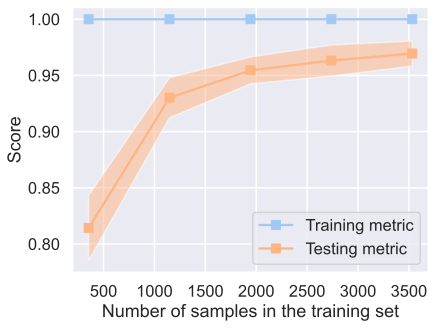

In [10]:
LearningCurveDisplay.from_estimator(rfc, Xtrain, ytrain, scoring = 'f1_macro', cv= None, score_type='both',line_kw={"marker": "s"})
# plt.savefig('LearningCurve_rfc.pdf', dpi=800, bbox_inches='tight')

In [14]:
# import shap
# import warnings
# warnings.filterwarnings("ignore")

In [15]:
# explainer = shap.TreeExplainer(rfc)
# shap_values = explainer.shap_values(Xtrain)

In [16]:
# print(shap_values)
# mean_shap_values = shap_values.mean(axis=0)
# shap.summary_plot(shap_values, Xtrain)

In [17]:
rfc.fit(Xtrain,ytrain)
rfc_pre =rfc.predict(Xtest)
print(accuracy_score(ytest,rfc_pre))
rfc_confusion = confusion_matrix(ytest, rfc_pre, labels=None, sample_weight=None, normalize=None)
print(rfc_confusion)

0.9653767820773931
[[318   1   0   2   0]
 [  4 129   0   0   1]
 [  0   0  89   4   0]
 [  5   0   0 277   0]
 [  3   1   1  12 135]]


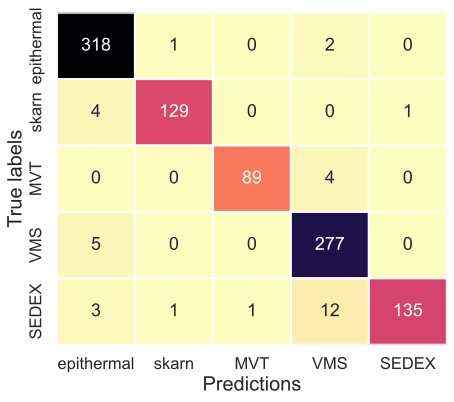

In [18]:
sns.set_theme(context='talk', style='darkgrid', palette='pastel', font='Arial', font_scale=1, color_codes=True, rc=None)

f, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(rfc_confusion, annot=True,fmt='d', cmap='magma_r', linewidths=2, xticklabels = label, yticklabels = label,cbar=None)
plt.xlabel("Predictions",font='Arial',fontsize=20)
plt.ylabel("True labels",font='Arial',fontsize=20)
# plt.savefig('confusion matrix_rfc.pdf', dpi=800, bbox_inches='tight')

## MLP

In [23]:
# Grid search for optimal hyperparameters
params_MLP = {'hidden_layer_sizes': [(200,10),(200,50),(200,100),(200,150),(200,200),
                                     (300,10),(300,50),(300,100),(300,150),(300,200),
                                     (400,10),(400,50),(400,100),(400,150),(400,200),
                                     (500,10),(500,50),(500,100),(500,150),(500,200),
                                     (600,10),(600,50),(600,100),(600,150),(600,200)]}
MLP_model = GridSearchCV(MLPClassifier(),params_MLP,scoring = 'f1_macro', n_jobs=-1)
MLP_model.fit(Xtrain, ytrain)

GridSearchCV(estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(200, 10), (200, 50),
                                                (200, 100), (200, 150),
                                                (200, 200), (300, 10),
                                                (300, 50), (300, 100),
                                                (300, 150), (300, 200),
                                                (400, 10), (400, 50),
                                                (400, 100), (400, 150),
                                                (400, 200), (500, 10),
                                                (500, 50), (500, 100),
                                                (500, 150), (500, 200),
                                                (600, 10), (600, 50),
                                                (600, 100), (600, 150),
                                                (600, 200)]},
             scoring='f1_macro')

0.958743464270567 {'hidden_layer_sizes': (300, 200)}


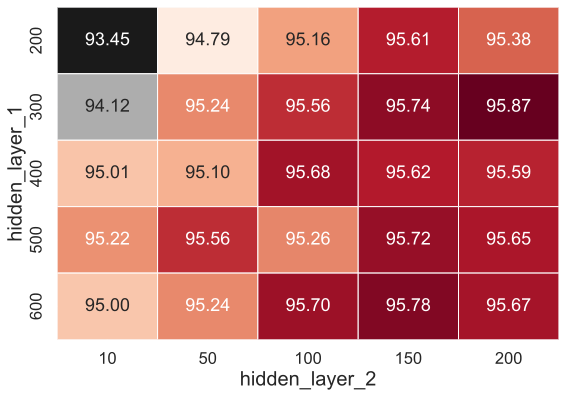

In [31]:
print(MLP_model.best_score_, MLP_model.best_params_)
MLP_params_scores = MLP_model.cv_results_['mean_test_score'].reshape(5,5)
# print(rf_model.cv_results_)
# print(rf_params_scores)
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(MLP_params_scores*100, annot=True,fmt=".2f", cmap='RdGy_r', linewidths=1, 
            xticklabels = [10,50,100,150,200], yticklabels =range(200,700,100), cbar=None)
plt.xlabel("hidden_layer_2",font='Arial',fontsize=20)
plt.ylabel("hidden_layer_1",font='Arial',fontsize=20)
# plt.savefig('Grid_search_mlp.pdf', dpi=800, bbox_inches='tight')

In [12]:
mp= MLPClassifier(hidden_layer_sizes=(300, 200), activation='relu', solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', 
                  learning_rate_init=0.001, power_t=0.5, max_iter=500, shuffle=True, random_state=None, tol=0.0001, verbose=False, 
                  warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, 
                  beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000)

In [13]:
mp.fit(Xtrain, ytrain)
mp_pre =mp.predict(Xtest)
score1_mp = f1_score(ytest, mp_pre, average=None)
score2_mp = precision_score(ytest, mp_pre,average=None)
score3_mp = recall_score(ytest, mp_pre,average=None)

In [14]:
df_mp = pd.DataFrame([score1_mp.tolist(),score2_mp.tolist(),score3_mp.tolist()],columns = ['MVT', 'SEDEX', 'VMS', 'epithermal', 'skarn'])
# df_mp.to_csv('Data\\mp_score.csv',index= False, header=None)
df_mp

epithermal     skarn       MVT       VMS     SEDEX
0    0.989114  0.973783  0.956522  0.959860  0.949495
1    0.987578  0.977444  0.967033  0.945017  0.972414
2    0.990654  0.970149  0.946237  0.975177  0.927632

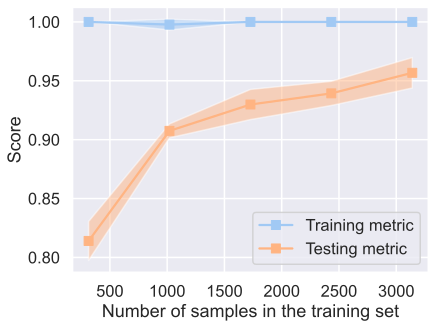

In [32]:
LearningCurveDisplay.from_estimator(mp, Xtrain, ytrain, scoring = 'f1_macro', score_type='both',line_kw={"marker": "s"})
# plt.savefig('LearningCurve_mlp.pdf', dpi=800, bbox_inches='tight')

In [33]:
mp.fit(Xtrain, ytrain)
mp_pre =mp.predict(Xtest)
print(accuracy_score(ytest,mp_pre))
print(mp.n_iter_)
mp_confusion = confusion_matrix(ytest, mp_pre, labels=None, sample_weight=None, normalize=None)
print(mp_confusion)
# print(mp.predict_proba(Xtest))

0.9755600814663951
154
[[319   0   0   2   0]
 [  2 129   0   0   3]
 [  0   0  89   3   1]
 [  1   1   1 277   2]
 [  0   0   1   7 144]]


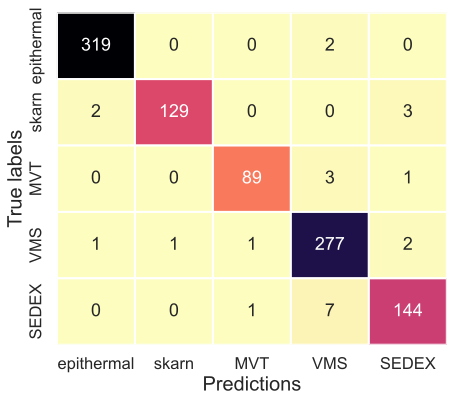

In [34]:
# sns.set_theme(context='talk', style='darkgrid', palette='pastel', font='Arial', font_scale=1, color_codes=True, rc=None)

f, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(mp_confusion, annot=True,fmt='d', cmap='magma_r', linewidths=2, xticklabels = label, yticklabels = label,cbar=None)
plt.xlabel("Predictions",font='Arial',fontsize=20)
plt.ylabel("True labels",font='Arial',fontsize=20)
# plt.savefig('confusion matrix_mlp.pdf', dpi=800, bbox_inches='tight')

## XGBoost

In [35]:
XGB = XGBClassifier(booster='gbtree',objective='multi:softprob', eval_metric='merror',gpu_id=-1)

params_XGB = {'n_estimators': [400,450,500,550,600,650,700,750,800,850],'eta': [0.05,0.1,0.2,0.3,0.5,0.7,1,2]}
XGB_model = GridSearchCV(XGBClassifier(),params_XGB,scoring = 'f1_macro', n_jobs=-1)
XGB_model.fit(Xtrain, ytrain)

[17:00:02] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
             n_jobs=-1,
             param_grid={'eta': [0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2],
                         'n_estimators': [400, 450, 500, 550, 600, 650, 700,
                                          750, 800, 850]},
             scoring='f1_macro')

0.9739704401849913 {'eta': 0.5, 'n_estimators': 650}


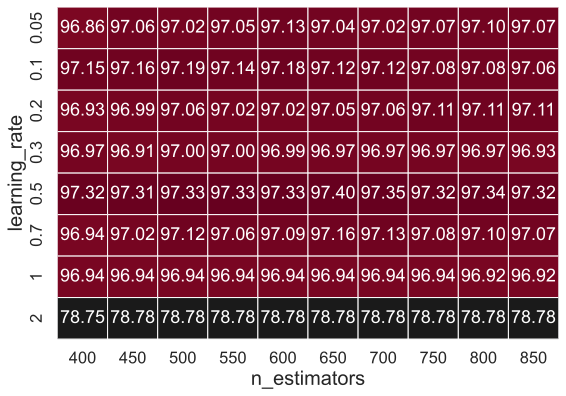

In [36]:
print(XGB_model.best_score_, XGB_model.best_params_)
XGB_params_scores = XGB_model.cv_results_['mean_test_score'].reshape(8,10)
# print(rf_model.cv_results_)
# print(rf_params_scores)
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(XGB_params_scores*100, annot=True,fmt=".2f", cmap='RdGy_r', linewidths=1, 
            xticklabels = [400,450,500,550,600,650,700,750,800,850], yticklabels = [0.05,0.1,0.2,0.3,0.5,0.7,1,2], cbar=None)
plt.xlabel("n_estimators",font='Arial',fontsize=20)
plt.ylabel("learning_rate",font='Arial',fontsize=20)
# plt.savefig('GridSearch_XGB.pdf', dpi=800, bbox_inches='tight')

In [15]:
XGB = XGBClassifier(
    n_estimators=650, eta=0.5, booster='gbtree',objective='multi:softprob', eval_metric='merror',gpu_id=-1
)

In [16]:
XGB.fit(Xtrain, ytrain)
XGB_pre =XGB.predict(Xtest)
score1_XGB = f1_score(ytest, XGB_pre, average=None)
score2_XGB = precision_score(ytest, XGB_pre,average=None)
score3_XGB = recall_score(ytest, XGB_pre,average=None)

D:\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [17]:
df_XGB = pd.DataFrame([score1_XGB.tolist(),score2_XGB.tolist(),score3_XGB.tolist()],columns = ['MVT', 'SEDEX', 'VMS', 'epithermal', 'skarn'])
# df_XGB.to_csv('Data\\XGB_score.csv',index= False, header=None)
df_XGB

epithermal     skarn       MVT       VMS     SEDEX
0    0.986047  0.966038  0.973262  0.968421  0.949495
1    0.981481  0.977099  0.968085  0.958333  0.972414
2    0.990654  0.955224  0.978495  0.978723  0.927632

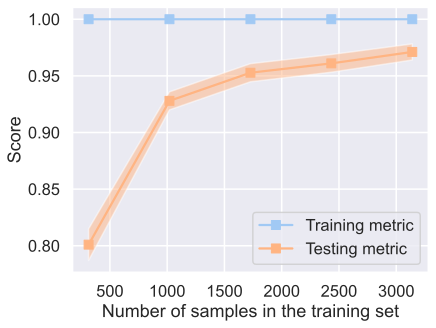

In [38]:
LearningCurveDisplay.from_estimator(XGB, Xtrain, ytrain, scoring = 'f1_macro', score_type='both',line_kw={"marker": "s"})
# plt.savefig('LearningCurve_XGB.pdf', dpi=800, bbox_inches='tight')

In [39]:
XGB.fit(Xtrain,ytrain)
XGB_pred=XGB.predict(Xtest)
print(accuracy_score(ytest,XGB_pred))
XGB_confusion = confusion_matrix(ytest, XGB_pred, labels=None, sample_weight=None, normalize=None)
print(XGB_confusion)
# print(svc.predict_proba(Xtest))

0.9714867617107943
[[318   2   0   1   0]
 [  3 128   1   0   2]
 [  0   0  91   2   0]
 [  1   1   2 276   2]
 [  2   0   0   9 141]]


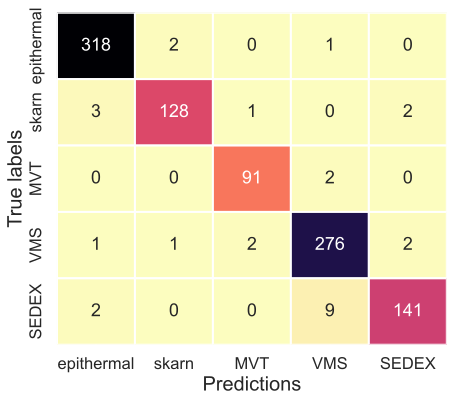

In [40]:
sns.set_theme(context='talk', style='darkgrid', palette='pastel', font='Arial', font_scale=1, color_codes=True, rc=None)

f, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(XGB_confusion, annot=True,fmt='d', cmap='magma_r', linewidths=2, xticklabels = label, yticklabels = label,cbar=None)
plt.xlabel("Predictions",font='Arial',fontsize=20)
plt.ylabel("True labels",font='Arial',fontsize=20)
# plt.savefig('confusion matrix_XGB.pdf', dpi=800, bbox_inches='tight')

In [41]:
print(XGB.feature_importances_)

[0.18614759 0.10149591 0.10429015 0.03258572 0.03344155 0.1949607
 0.03502592 0.05755423 0.035698   0.11434067 0.07268309 0.03177634]


In [21]:
XGB_explainer = shap.Explainer(XGB)
shap_values = XGB_explainer(Xtrain)
# print(shap_values)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


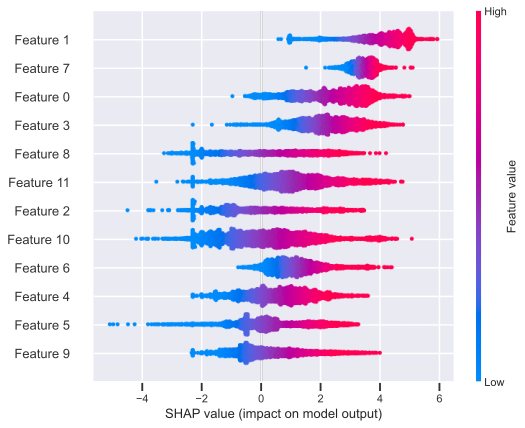

In [22]:
mean_shap_values = shap_values.mean(axis=0)
# print(mean_shap_values)
shap.summary_plot(shap_values.data, Xtrain)

## SVM

In [42]:
params_svc = {'C':np.logspace(-5,5,base=10,num=11), 'gamma':[0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1, 2]}
svc_model = GridSearchCV(svm.SVC(),params_svc,scoring = 'f1_macro', n_jobs=-1)
svc_model.fit(Xtrain, ytrain)

GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05]),
                         'gamma': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1, 2]},
             scoring='f1_macro')

0.972009137318798 {'C': 100.0, 'gamma': 0.3}


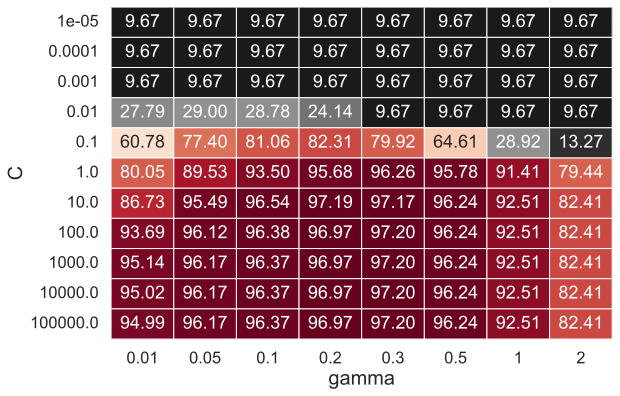

In [43]:
print(svc_model.best_score_, svc_model.best_params_)
svc_params_scores = svc_model.cv_results_['mean_test_score'].reshape(11,8)
# print(rf_model.cv_results_)
# print(rf_params_scores)
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(svc_params_scores*100, annot=True,fmt=".2f", cmap='RdGy_r', linewidths=1, 
            xticklabels = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1, 2], yticklabels =np.logspace(-5,5,base=10,num=11), cbar=None)
plt.xlabel("gamma",font='Arial',fontsize=20)
plt.ylabel("C",font='Arial',fontsize=20)
# plt.savefig('GridSearch_svc.pdf', dpi=800, bbox_inches='tight')

In [18]:
svc = svm.SVC(C=100, kernel='rbf', degree=3, gamma=0.3, coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, 
              class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)

In [19]:
svc.fit(Xtrain, ytrain)
svc_pre =svc.predict(Xtest)
score1_svc = f1_score(ytest, svc_pre, average=None)
score2_svc = precision_score(ytest, svc_pre,average=None)
score3_svc = recall_score(ytest, svc_pre,average=None)

In [20]:
df_svc = pd.DataFrame([score1_svc.tolist(),score2_svc.tolist(),score3_svc.tolist()],columns = ['MVT', 'SEDEX', 'VMS', 'epithermal', 'skarn'])
# df_svc.to_csv('Data\\svc_score.csv',index= False, header=None)
df_svc

epithermal     skarn       MVT       VMS     SEDEX
0    0.989181  0.984848  0.962162  0.965157  0.945578
1    0.981595  1.000000  0.967391  0.948630  0.978873
2    0.996885  0.970149  0.956989  0.982270  0.914474

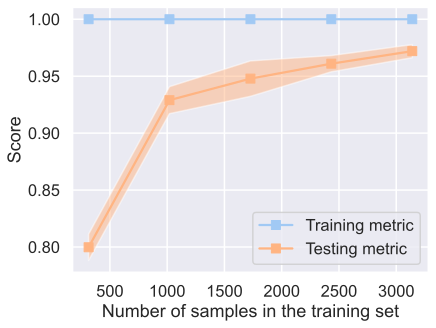

In [45]:
LearningCurveDisplay.from_estimator(svc, Xtrain, ytrain, scoring = 'f1_macro', score_type='both',line_kw={"marker": "s"})
# plt.savefig('LearningCurve_svc.pdf', dpi=800, bbox_inches='tight')

In [46]:
svc.fit(Xtrain,ytrain)
svc_pred=svc.predict(Xtest)
print(accuracy_score(ytest,svc_pred))
print(svc.n_iter_)
svc_confusion = confusion_matrix(ytest, svc_pred, labels=None, sample_weight=None, normalize=None)
print(svc_confusion)
# print(svc.predict_proba(Xtest))

0.9725050916496945
[1366 1051 1866 1303  820 1306  945 1415 1101 2512]
[[320   0   0   1   0]
 [  2 130   1   0   1]
 [  2   0  89   2   0]
 [  1   0   2 277   2]
 [  1   0   0  12 139]]


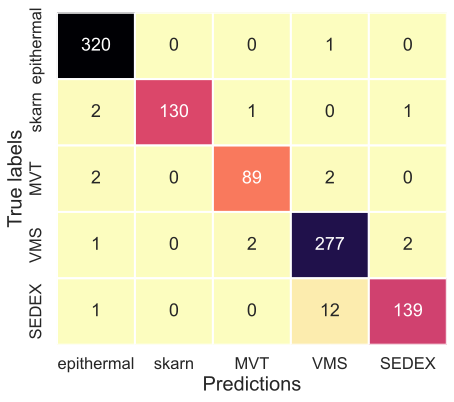

In [47]:
sns.set_theme(context='talk', style='darkgrid', palette='pastel', font='Arial', font_scale=1, color_codes=True, rc=None)

f, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(svc_confusion, annot=True,fmt='d', cmap='magma_r', linewidths=2, xticklabels = label, yticklabels = label,cbar=None)
plt.xlabel("Predictions",font='Arial',fontsize=20)
plt.ylabel("True labels",font='Arial',fontsize=20)
# plt.savefig('confusion matrix_svc.pdf', dpi=800, bbox_inches='tight')

In [27]:
linearsvc = svm.LinearSVC(penalty='l2', loss='squared_hinge', dual=False, tol=0.001, C=1.0, multi_class='ovr', fit_intercept=True, 
                          intercept_scaling=1, class_weight=None, verbose=0, random_state=None, max_iter=10000)
linearsvc.fit(Xtrain,ytrain)
linearsvc_pred=linearsvc.predict(Xtest)
print(accuracy_score(ytest,linearsvc_pred))

0.7841140529531568


# Output models

In [7]:
# code0 = m2c.export_to_visual_basic(dtc, function_name = 'dtc_pred')
# print(code0)

In [9]:
code1 = m2c.export_to_visual_basic(rfc, function_name = 'rfc_pred')
# print(code1)

In [10]:
# file_handle=open('RF_model.txt',mode='w')
# file_handle.write(code1)

4205745

In [7]:
code2 = m2c.export_to_visual_basic(XGB, function_name = 'XGB_pred')
# print(code2)

In [8]:
# file_handle=open('XGB_model.txt',mode='w')
# file_handle.write(code2)

677245

In [7]:
code3 = m2c.export_to_visual_basic(svc, function_name = 'svc_pred')
# print(code3)

In [9]:
# file_handle=open('svc_rbf_model.txt',mode='w')
# file_handle.write(code3)

1056410

In [ ]:
code4 = m2c.export_to_visual_basic(linearsvc, function_name = 'linearsvc_pred')
# print(code4)

# Visualizing

# PCA

In [4]:
sns.set_theme(style='white')

In [5]:
log_X = np.log10(X)

In [6]:
pca = decomposition.PCA(n_components=2, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', n_oversamples=10, 
                        power_iteration_normalizer='auto', random_state=None)
pca.fit(log_X)
X_pca = pca.transform(log_X)
print(pca.explained_variance_ratio_,'\n',pca.components_,'\n',pca.components_.shape)
X_mean = log_X - np.mean(log_X, axis=0)
print(np.mean(log_X, axis=0))
print(X_mean.shape)
r = np.dot(X_mean, pca.components_.T)
print(r)

[0.34016813 0.19257854] 
 [[-0.32795828 -0.15716336 -0.27879519 -0.06432278 -0.00437644  0.34387874
   0.15266825 -0.03757131 -0.59481807 -0.20835005  0.36060654  0.34004789]
 [ 0.10688294  0.03379408 -0.14981135  0.3935323   0.32442558 -0.03525008
   0.23022773  0.03379716  0.34063265  0.40585204  0.53446271  0.28824371]] 
 (2, 12)
[ 2.35149845  4.06058391 -0.21320331  2.16374955  0.5594538   0.35337841
  1.14125983  3.44642316  0.17837328  0.21392093  0.10308612  0.99989674]
(4908, 12)
[[-1.79193987e+00  1.78870780e+00]
 [-2.23490973e+00 -1.16320755e+00]
 [-2.36784905e+00  1.95248284e-03]
 ...
 [ 5.28651093e-01 -5.02755886e-01]
 [-8.49843751e-02 -1.42967836e+00]
 [-1.06474227e-01 -1.45252425e+00]]


In [7]:
newdata = pd.DataFrame(np.c_[X_pca,y],columns=['pc1','pc2','type'])
print(newdata)

           pc1       pc2  type
0    -1.791940  1.788708   3.0
1    -2.234910 -1.163208   3.0
2    -2.367849  0.001952   3.0
3    -2.898028 -0.043466   3.0
4    -2.282860 -0.305267   3.0
...        ...       ...   ...
4903  0.128390 -1.086707   1.0
4904 -0.468387 -1.798197   1.0
4905  0.528651 -0.502756   1.0
4906 -0.084984 -1.429678   1.0
4907 -0.106474 -1.452524   1.0

[4908 rows x 3 columns]


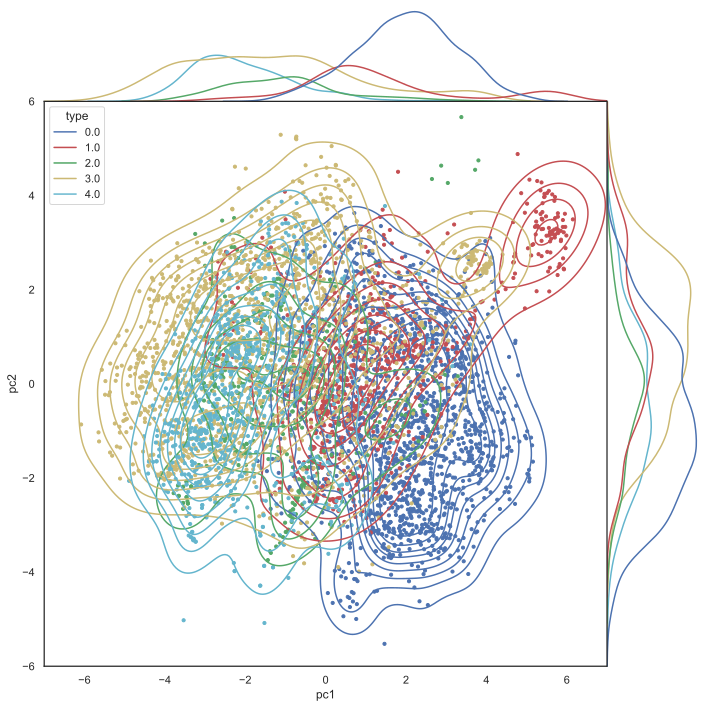

In [8]:
g = sns.jointplot(data=newdata, x='pc1', y='pc2', hue='type', kind='kde', height=10, ratio=6, space=0, dropna=False, 
                  xlim=[-7,7], ylim=[-6,6], color=None, palette=color, hue_order=None, hue_norm=None, marginal_ticks=False, 
                  joint_kws=None, marginal_kws=None)
for i in range(label_length):
    plt.scatter(X_pca[y==i,0],X_pca[y==i,1],c=color[i],s=10,alpha=1,label=y)

In [28]:
kernelpca = decomposition.KernelPCA(n_components=2, kernel='rbf', gamma=None, degree=3, coef0=1, kernel_params=None, alpha=1.0, 
                                    fit_inverse_transform=True, eigen_solver='auto', tol=0, max_iter=None, iterated_power='auto', 
                                    remove_zero_eig=False, random_state=None, copy_X=True, n_jobs=None)
kernelpca.fit(log_X)
Xnew = kernelpca.transform(log_X)

In [42]:
print(kernelpca.eigenvalues_,'\n',kernelpca.eigenvectors_,'\n',kernelpca.dual_coef_.shape)

[393.9234713  274.02154257] 
 [[ 0.01309077  0.02544344]
 [ 0.01100012  0.00530178]
 [ 0.01453089  0.01394045]
 ...
 [-0.01023146  0.00537971]
 [-0.00512069 -0.00163799]
 [-0.00484039 -0.00221129]] 
 (4908, 12)


In [40]:
kernelpca_data = pd.DataFrame(np.c_[Xnew,y],columns=['pc1','pc2','type'])
print(kernelpca_data)

           pc1       pc2  type
0     0.259819  0.421180   3.0
1     0.218325  0.087764   3.0
2     0.288402  0.230765   3.0
3     0.235104  0.094507   3.0
4     0.280098  0.125251   3.0
...        ...       ...   ...
4903 -0.131596  0.028820   1.0
4904 -0.038934 -0.063714   1.0
4905 -0.203069  0.089054   1.0
4906 -0.101633 -0.027115   1.0
4907 -0.096070 -0.036605   1.0

[4908 rows x 3 columns]


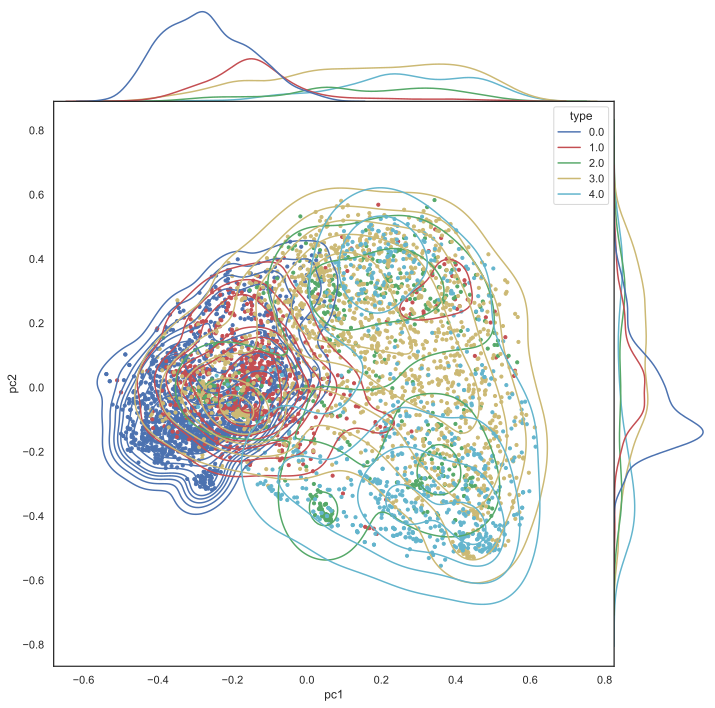

In [41]:
g = sns.jointplot(data=kernelpca_data, x='pc1', y='pc2', hue='type', kind='kde', height=10, ratio=6, space=0,dropna=False, 
#                   xlim=[-0.6,0.7], ylim=[-0.7,0.7], 
                  color=None, palette=color, hue_order=None, hue_norm=None, marginal_ticks=False, joint_kws=None, 
                  marginal_kws=None)
for i in range(label_length):
    plt.scatter(Xnew[y==i,0],Xnew[y==i,1],c=color[i],s=10,alpha=1,label=y)
# plt.savefig('PCA_rbf.pdf', dpi=800, bbox_inches='tight')

# TSNE

In [13]:
tsne = TSNE(n_components=2, perplexity=30.0, early_exaggeration=12.0, learning_rate='auto', n_iter=1000, n_iter_without_progress=300, 
              min_grad_norm=1e-07, metric='euclidean', metric_params=None, init='pca', verbose=0, random_state=None, method='barnes_hut', 
              angle=0.5, n_jobs=None, square_distances='deprecated')
tsne.fit(log_X)
X_tsne = tsne.fit_transform(log_X)

In [14]:
tsne_data = pd.DataFrame(np.c_[X_tsne,y],columns=['tsne1','tsne2','type'])
print(tsne_data)

          tsne1      tsne2  type
0    -24.213352   8.440670   3.0
1    -28.942505   0.687004   3.0
2    -29.082058   0.682141   3.0
3    -30.440210  -1.027300   3.0
4    -31.499069  -1.555772   3.0
...         ...        ...   ...
4903   4.405927 -14.052561   1.0
4904   3.241234 -13.993926   1.0
4905   6.849348 -13.271328   1.0
4906   3.737779 -14.269770   1.0
4907   3.730156 -14.278610   1.0

[4908 rows x 3 columns]


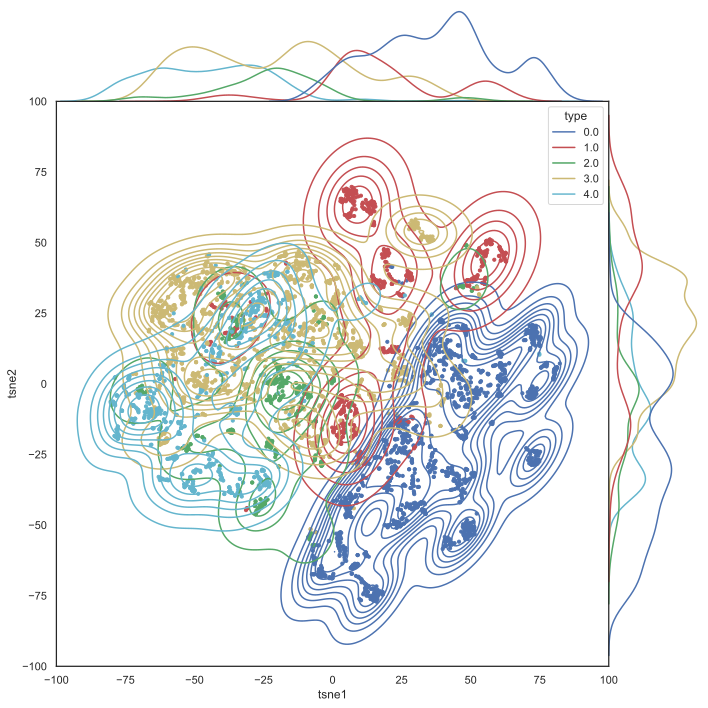

In [17]:
g = sns.jointplot(data=tsne_data, x='tsne1', y='tsne2', hue='type', kind='kde', height=10, ratio=6, space=0, dropna=False, xlim=[-100,100], 
                  ylim=[-100,100], color=None, palette=color, hue_order=None, hue_norm=None, marginal_ticks=False, joint_kws=None, 
                  marginal_kws=None)
for i in range(label_length):
    plt.scatter(X_tsne[y==i,0],X_tsne[y==i,1],c=color[i],s=10,alpha=1,label=y)
# plt.savefig('TSNE.pdf', dpi=800, bbox_inches='tight')